In [1]:
import os
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import numpy as np
import arff
from scalability_tools import *
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

## Load the Data

In [2]:
path = '../datasets/CAL500/CAL500.arff'
data = arff.load(open(path, 'rt'))
data = np.array(data['data']).astype(np.float32)
data, labels = data[:, :68], data[:, 68:]
# data = torch.from_numpy(np.array(data))

device = torch.device('cuda:0')

In [3]:
hparams_dict = {
    'name': 'CAL500',
    'inputs': 300,
    'outputs': 6,
    'time_constant': 300,
    'alpha_a': 0.42,
    'alpha_m': 0.07,
    'w_max': 100.0,
    'w_min': -100.0,
    'lr': 5e-4,
    'sim_time': 600,
    'n_epochs': 3,
    'print_every': 200,
    'seed': 2,
    'ckpt_dir': './checkpoints/CAL500/mvmd',
    'load_from_file': None,
    'device': device
}

In [4]:
num_samples = [100, 300, 500]
num_samples_list = [50, 150, 250, 350, 500]

num_features = [20, 40, 60]
num_features_list = [10, 20, 30, 40, 50, 60]

num_labels = [10, 20, 30]
num_labels_list = [10, 20, 30, 40, 50]

plot_styles = ['k^--', 'kD-', 'ko--']
bar_styles = ['x', '*', '\\', 'o', '+']

samples_dict = {'Samples: {}'.format(s): [] for s in num_samples}
features_dict = {'Features: {}'.format(s): [] for s in num_features}
labels_dict = {'Labels: {}'.format(s): [] for s in num_labels}

In [5]:
def dict_max_min(data_dict):
    vals = []
    for k, v in data_dict.items():
        vals.append(v)
    vals = np.array(vals)
    return np.max(vals)

def plot_num_neurons(class1_neuron_dict, class0_neuron_dict, neuron_time_dict, weight_time_dict, xlabels, xtitle, name):
    xvals = [str(l) for l in xlabels]

    ytitle = '# Intereurons'
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    yticks = [0.0, 0.20, 0.40, 0.60, 0.80, 1.0]
    yvals = [str(int(k*dict_max_min(class1_neuron_dict))) for k in yticks]

    for i, (k, v) in enumerate(class1_neuron_dict.items()):
        style = plot_styles[i]
        axs[0].plot(xlabels, v, style, linewidth=2, label=k, markersize=12)

    axs[0].set_xticks(xlabels)
    axs[0].set_xticklabels(xvals, fontsize=16, rotation=90)
    axs[0].set_yticks(yticks, yvals)
    axs[0].set_ylabel(ytitle, fontsize=16)
    axs[0].set_xlabel(xtitle, fontsize=16)
    axs[0].set_title(name + '$S^+$ Interneurons', fontsize=18)

    yvals = [str(int(k*dict_max_min(class0_neuron_dict))) for k in yticks]

    for i, (k, v) in enumerate(class0_neuron_dict.items()):
        style = plot_styles[i]
        axs[1].plot(xlabels, v, style, linewidth=2, label=k, markersize=12)

    axs[1].set_xticks(xlabels)
    axs[1].set_xticklabels(xvals, fontsize=16, rotation=90)
    axs[1].set_yticks(yticks, yvals)
    axs[1].set_ylabel(ytitle, fontsize=16)
    axs[1].set_xlabel(xtitle, fontsize=16)
    axs[1].set_title(name + '$S^-$ Interneurons', fontsize=18)

    yvals = [str(int(k*dict_max_min(neuron_time_dict))) for k in yticks]

    for i, (k, v) in enumerate(neuron_time_dict.items()):
        style = plot_styles[i]
        axs[2].plot(xlabels, v, style, linewidth=2, label=k, markersize=12)

    axs[2].set_xticks(xlabels)
    axs[2].set_xticklabels(xvals, fontsize=16, rotation=90)
    axs[2].set_yticks(yticks, yvals)
    axs[2].set_ylabel('Time taken (s)', fontsize=16)
    axs[2].set_xlabel(xtitle, fontsize=16)
    axs[2].set_title(name + 'Interneuron Addition Time', fontsize=18)

    yvals = [str(int(k*dict_max_min(weight_time_dict))) for k in yticks]

    for i, (k, v) in enumerate(weight_time_dict.items()):
        style = plot_styles[i]
        axs[3].plot(xlabels, v, style, linewidth=2, label=k, markersize=12)

    axs[3].set_xticks(xlabels)
    axs[3].set_xticklabels(xvals, fontsize=16, rotation=90)
    axs[3].set_yticks(yticks, yvals)
    axs[3].set_ylabel('Time taken (s)', fontsize=16)
    axs[3].set_xlabel(xtitle, fontsize=16)
    axs[3].set_title(name + 'Weight Update Time', fontsize=18)

    # handles, labels = axs[2].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='lower center', fontsize=16)

    # lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels, loc='lower center', ncol=len(class1_neuron_dict.keys()), fontsize=16)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, -0.1), fontsize=16)

    plt.subplots_adjust(hspace=0.2, wspace=0.3)
    plt.show()
    return

# def plot_times(weight_update_time_dict, xlabels, xtitle, name):
#     xvals = [str(l) for l in xlabels]

#     ytitle = 'Time taken (s)'
#     fig, axs = plt.subplots(1, 1, figsize=(5, 5))
#     plt.tight_layout(rect=[0, 0.1, 1, 1])
#     yticks = [0.0, 0.20, 0.40, 0.60, 0.80, 1.0]
#     yvals = [str(int(k*dict_max_min(weight_update_time_dict))) for k in yticks]

#     for i, (k, v) in enumerate(weight_update_time_dict.items()):
#         style = plot_styles[i]
#         axs.plot(xlabels, v, style, linewidth=2, label=k, markersize=12)

#     axs.set_xticks(xlabels)
#     axs.set_xticklabels(xvals, fontsize=16, rotation=90)
#     axs.set_yticks(yticks, yvals)
#     axs.set_ylabel(ytitle, fontsize=16)
#     axs.set_xlabel(xtitle, fontsize=16)
#     axs.set_title(name + 'Weight Update Time', fontsize=18)

#     # handles, labels = axs.get_legend_handles_labels()
#     # fig.legend(handles, labels, loc='lower center', fontsize=16)

#     # lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#     # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#     # fig.legend(lines, labels, loc='lower center', ncol=len(weight_update_time_dict.keys()), fontsize=16)

#     handles, labels = axs[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, -0.1), fontsize=16)

#     plt.subplots_adjust(hspace=0.2, wspace=0.3)
#     plt.show()
#     return

## Number of features 

100%|██████████| 3/3 [14:39<00:00, 293.03s/it]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWar

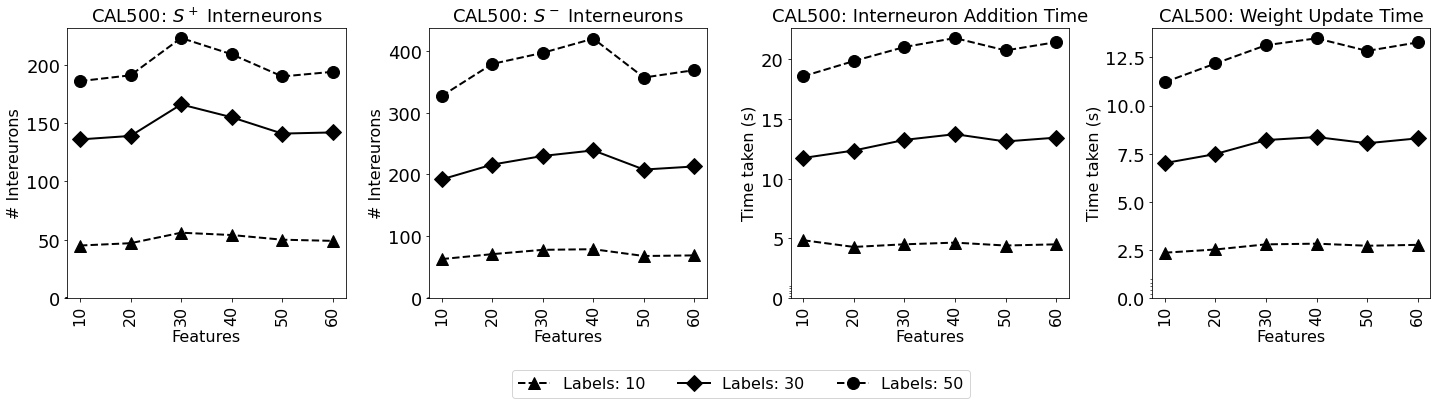

In [6]:
class1_dict = deepcopy(labels_dict)
class0_dict = deepcopy(labels_dict)
neuron_time_dict = deepcopy(labels_dict)
weight_time_dict = deepcopy(labels_dict)

for num_label in tqdm(num_labels):
    key = 'Labels: {}'.format(num_label)
    times, class1, class0 = neuron_addition_features(data, labels, device, num_features_list, num_label, 150, hparams_dict)
    class1_dict[key] = class1
    class0_dict[key] = class0
    neuron_time_dict[key] = times
    times = weight_update_features(data, labels, device, num_features_list, num_label, 150, hparams_dict)
    weight_time_dict[key] = times

plot_num_neurons(class1_dict, class0_dict, neuron_time_dict, weight_time_dict, num_features_list, 'Features', 'CAL500: ')

100%|██████████| 3/3 [15:29<00:00, 309.83s/it]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWar

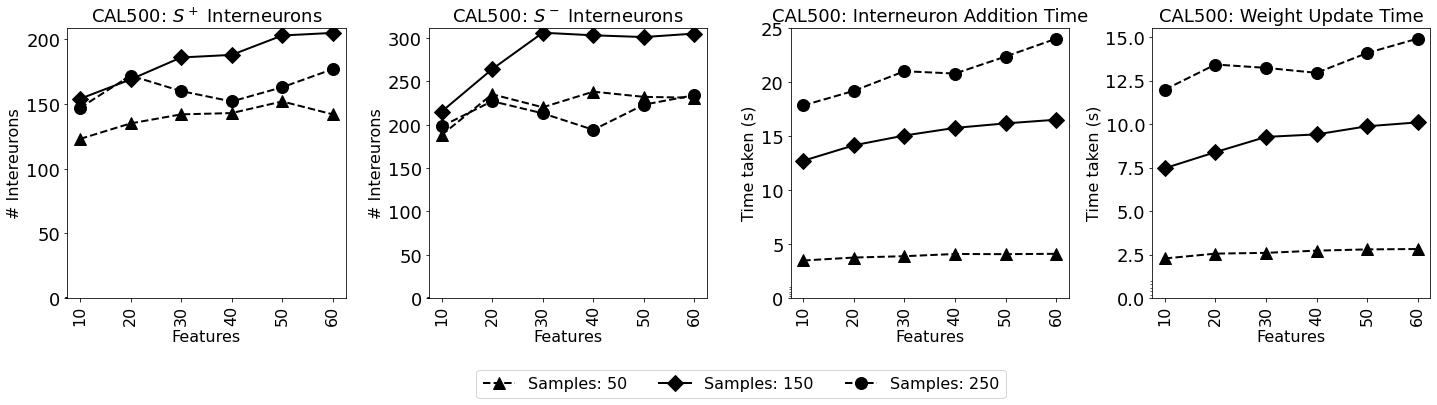

In [7]:
class1_dict = deepcopy(samples_dict)
class0_dict = deepcopy(samples_dict)
neuron_time_dict = deepcopy(samples_dict)
weight_time_dict = deepcopy(samples_dict)

for num_sample in tqdm(num_samples):
    key = 'Samples: {}'.format(num_sample)
    times, class1, class0 = neuron_addition_features(data, labels, device, num_features_list, 30, num_sample, hparams_dict)
    class1_dict[key] = class1
    class0_dict[key] = class0
    neuron_time_dict[key] = times
    times = weight_update_features(data, labels, device, num_features_list, 30, num_sample, hparams_dict)
    weight_time_dict[key] = times

plot_num_neurons(class1_dict, class0_dict, neuron_time_dict, weight_time_dict, num_features_list, 'Features', 'CAL500: ')

## Number of Labels

100%|██████████| 3/3 [23:20<00:00, 466.90s/it]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWar

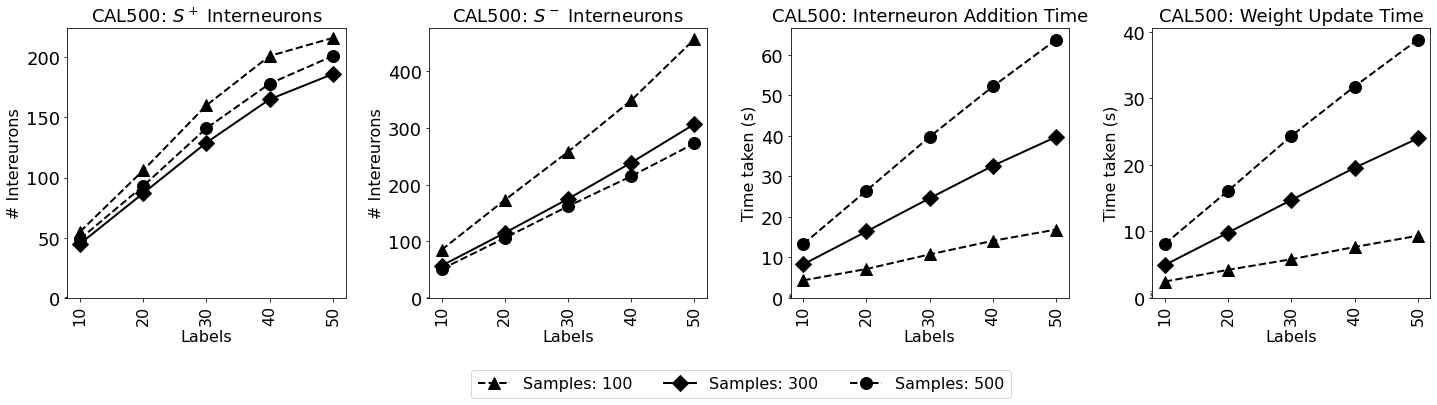

In [6]:
class1_dict = deepcopy(samples_dict)
class0_dict = deepcopy(samples_dict)
neuron_time_dict = deepcopy(samples_dict)
weight_time_dict = deepcopy(samples_dict)

for num_sample in tqdm(num_samples):
    key = 'Samples: {}'.format(num_sample)
    times, class1, class0 = neuron_addition_labels(data, labels, device, 40, num_labels_list, num_sample, hparams_dict)
    class1_dict[key] = class1
    class0_dict[key] = class0
    neuron_time_dict[key] = times
    times = weight_update_labels(data, labels, device, 40, num_labels_list, num_sample, hparams_dict)
    weight_time_dict[key] = times

plot_num_neurons(class1_dict, class0_dict, neuron_time_dict, weight_time_dict, num_labels_list, 'Labels', 'CAL500: ')

100%|██████████| 3/3 [12:30<00:00, 250.17s/it]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWar

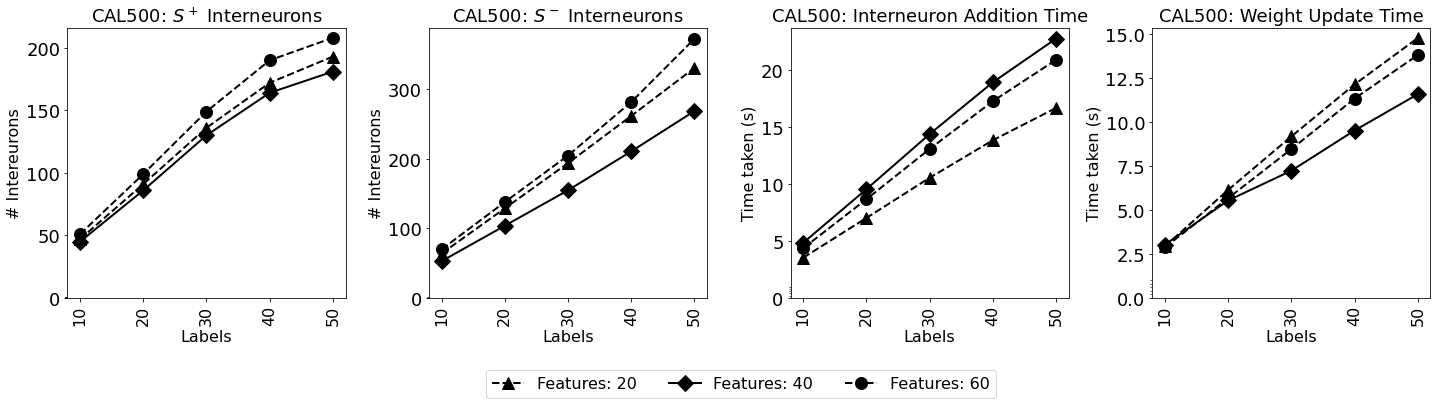

In [7]:
class1_dict = deepcopy(features_dict)
class0_dict = deepcopy(features_dict)
neuron_time_dict = deepcopy(features_dict)
weight_time_dict = deepcopy(features_dict)

for num_feature in tqdm(num_features):
    key = 'Features: {}'.format(num_feature)
    times, class1, class0 = neuron_addition_labels(data, labels, device, num_feature, num_labels_list, 150, hparams_dict)
    class1_dict[key] = class1
    class0_dict[key] = class0
    neuron_time_dict[key] = times
    times = weight_update_labels(data, labels, device, num_feature, num_labels_list, 150, hparams_dict)
    weight_time_dict[key] = times

plot_num_neurons(class1_dict, class0_dict, neuron_time_dict, weight_time_dict, num_labels_list, 'Labels', 'CAL500: ')

## Number of samples

100%|██████████| 3/3 [20:34<00:00, 411.40s/it]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWar

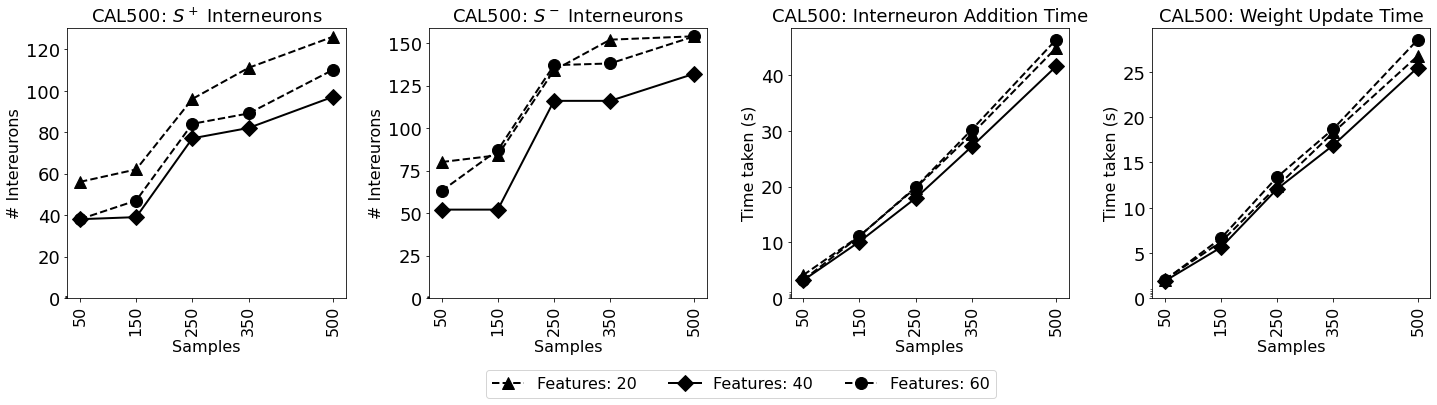

In [6]:
class1_dict = deepcopy(features_dict)
class0_dict = deepcopy(features_dict)
neuron_time_dict = deepcopy(features_dict)
weight_time_dict = deepcopy(features_dict)

for num_feature in tqdm(num_features):
    key = 'Features: {}'.format(num_feature)
    times, class1, class0 = neuron_addition_samples(data, labels, device, num_feature, 30, num_samples_list, hparams_dict)
    class1_dict[key] = class1
    class0_dict[key] = class0
    neuron_time_dict[key] = times
    times = weight_update_samples(data, labels, device, num_feature, 30, num_samples_list, hparams_dict)
    weight_time_dict[key] = times

plot_num_neurons(class1_dict, class0_dict, neuron_time_dict, weight_time_dict, num_samples_list, 'Samples', 'CAL500: ')

100%|██████████| 3/3 [11:59<00:00, 239.72s/it]
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/airl-gpu4/anaconda3/envs/DL_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWar

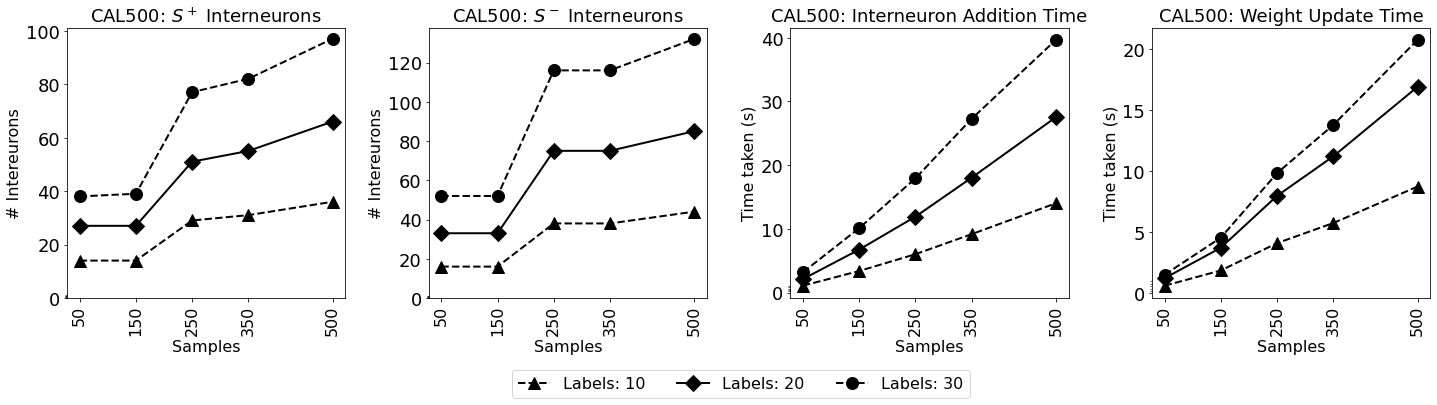

In [7]:
class1_dict = deepcopy(labels_dict)
class0_dict = deepcopy(labels_dict)
neuron_time_dict = deepcopy(labels_dict)
weight_time_dict = deepcopy(labels_dict)

for num_label in tqdm(num_labels):
    key = 'Labels: {}'.format(num_label)
    times, class1, class0 = neuron_addition_samples(data, labels, device, 40, num_label, num_samples_list, hparams_dict)
    class1_dict[key] = class1
    class0_dict[key] = class0
    neuron_time_dict[key] = times
    times = weight_update_samples(data, labels, device, 40, num_label, num_samples_list, hparams_dict)
    weight_time_dict[key] = times

plot_num_neurons(class1_dict, class0_dict, neuron_time_dict, weight_time_dict, num_samples_list, 'Samples', 'CAL500: ')